In [ ]:
# Cell 1 — Load & inspect BRD4 data (reads from data/, not data/processed)

from pathlib import Path
import pandas as pd
import numpy as np

# --- Option A: auto-detect project root (works regardless of CPII/cpii) ---
def find_project_root(start: Path | None = None) -> Path:
    start = (start or Path.cwd()).resolve()
    for p in [start, *start.parents]:
        if (p / "pyproject.toml").exists() or (p / ".git").exists() or (p / "README.md").exists():
            return p
    return start

PROJECT_ROOT = find_project_root()


In [ ]:
# Cell A — Bootstrap: (re)create df, paths, and column names safely

from pathlib import Path
import pandas as pd
import numpy as np

# --- Find your repo root (auto). If you prefer, uncomment the forced path line below. ---
def find_project_root(start: Path | None = None) -> Path:
    start = (start or Path.cwd()).resolve()
    for p in [start, *start.parents]:
        if (p / "pyproject.toml").exists() or (p / ".git").exists() or (p / "README.md").exists():
            return p
    return start

PROJECT_ROOT = find_project_root()
# PROJECT_ROOT = Path("/Users/pabloperezgonzalez/CPII/F.I.T-Proteins").resolve()  # <- use this if you want to force it

def R(rel: str) -> Path:
    p = Path(rel)
    return p if p.is_absolute() else (PROJECT_ROOT / rel)

def pick_file(kind: str) -> Path:
    """Pick train/test parquet from data/ or data/processed by common names."""
    assert kind in {"train","test"}
    preferred = [
        f"data/{kind}_brd4_50k_clean_blocks.parquet",
        f"data/{kind}_brd4_50k_stratified.parquet",
        f"data/{kind}_brd4_50k.parquet",
        f"data/processed/{kind}_brd4_50k_clean_blocks.parquet",
        f"data/processed/{kind}_brd4_50k_stratified.parquet",
        f"data/processed/{kind}_brd4_50k.parquet",
    ]
    for rel in preferred:
        p = R(rel)
        if p.exists():
            return p
    # fallback: search broadly
    hits = []
    for base in [R("data"), R("data/processed")]:
        if base.exists():
            hits += list(base.rglob(f"{kind}*brd4*50k*.parquet"))
            hits += list(base.rglob(f"{kind}*brd4*.parquet"))
            hits += list(base.glob(f"{kind}*.parquet"))
    if not hits:
        raise FileNotFoundError(f"Could not find a {kind} parquet under data/ or data/processed/.")
    return sorted(hits)[0]

TRAIN_PATH = pick_file("train")
TEST_PATH  = pick_file("test")

df = pd.read_parquet(TRAIN_PATH)

# Prefer the names we already confirmed from your output; fall back to heuristics if missing.
def infer_col(df, candidates):
    cols = list(df.columns)
    lower = {c.lower(): c for c in cols}
    for c in candidates:
        if c in cols: return c
        if c.lower() in lower: return lower[c.lower()]
    return None

SMILES_COL = "molecule_smiles" if "molecule_smiles" in df.columns else infer_col(
    df, ["smiles","SMILES","smiles_clean","smiles_str","mol_smiles"]
)
LABEL_COL  = "binds" if "binds" in df.columns else infer_col(
    df, ["label","y","target","is_active","active","binds"]
)

if SMILES_COL is None or LABEL_COL is None:
    raise KeyError(f"Could not determine SMILES/LABEL columns. Columns: {list(df.columns)}")

print("Project root:", PROJECT_ROOT)
print("Using train:", TRAIN_PATH)
print("Using test :", TEST_PATH)
print("df shape   :", df.shape)
print(f"Columns ok → SMILES_COL='{SMILES_COL}', LABEL_COL='{LABEL_COL}'")
print("Pos rate   :", float(pd.to_numeric(df[LABEL_COL], errors='coerce').fillna(0).astype(int).mean()))


Project root: /Users/pabloperezgonzalez/cpii/F.I.T-PROTEINS
Using train: /Users/pabloperezgonzalez/cpii/F.I.T-PROTEINS/data/train_brd4_50k_stratified.parquet
Using test : /Users/pabloperezgonzalez/cpii/F.I.T-PROTEINS/data/test_brd4_50k.parquet
df shape   : (50000, 7)
Columns ok → SMILES_COL='molecule_smiles', LABEL_COL='binds'
Pos rate   : 0.00538


In [6]:
# Cell 1d — Inspect columns and auto-guess SMILES + label columns from your loaded df

import numpy as np
import pandas as pd
from IPython.display import display
import re

# Show columns, a preview, and dtypes
print("Columns:", list(df.columns))
display(df.head(3))
print("\nDtypes:\n", df.dtypes)

# ---- Heuristics to find a SMILES-like text column ----
def is_smiles_series(s: pd.Series, sample_k: int = 50) -> bool:
    if not (s.dtype == object or str(s.dtype).startswith("string")):
        return False
    sample = s.dropna().astype(str).head(sample_k).tolist()
    if not sample:
        return False
    alphabet = set("ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789[]()=#@+-\\/.:")
    ratios = []
    for st in sample:
        if not st:
            continue
        ratios.append(sum(ch in alphabet for ch in st) / len(st))
    # looks like SMILES if mostly valid chars and not super short
    return (np.mean(ratios) > 0.8) and (np.mean([len(st) for st in sample]) > 10)

# collect candidates by name hints and by content check
name_hints = [c for c in df.columns if any(k in c.lower() for k in ["smiles", "smile", "mol", "structure"])]
content_hits = [c for c in df.columns if is_smiles_series(df[c])]
smiles_candidates = list(dict.fromkeys(name_hints + content_hits))  # unique, keep order
print("\nHeuristic SMILES-like columns:", smiles_candidates)

# ---- Heuristics to find a binary label column ----
def is_binary_label(s: pd.Series) -> bool:
    if s.dtype == bool:
        return True
    # try numeric
    vals = pd.to_numeric(s, errors="coerce")
    u = np.unique(vals.dropna())
    if len(u) <= 2 and np.all(np.isin(u, [0, 1])):
        return True
    # try common string labels
    lower = s.astype(str).str.lower().str.strip()
    uniq = set(lower.unique())
    if uniq <= {"0","1","true","false","yes","no","active","inactive","pos","neg"}:
        return True
    return False

label_candidates = [c for c in df.columns if is_binary_label(df[c])]
# prefer common names if present
preferred_order = {"label":0,"y":0,"target":0,"is_active":0,"active":0,"binds":0}
label_candidates.sort(key=lambda c: (preferred_order.get(c.lower(), 1), c.lower()))
print("Heuristic label columns:", label_candidates)

# ---- First guesses ----
SMILES_COL = smiles_candidates[0] if smiles_candidates else None
LABEL_COL  = label_candidates[0] if label_candidates else None
print(f"\nGuess -> SMILES_COL='{SMILES_COL}', LABEL_COL='{LABEL_COL}'")

# If we have guesses, preview counts
if SMILES_COL is not None and LABEL_COL is not None:
    labels_preview = df[LABEL_COL]
    if labels_preview.dtype == object:
        labels_preview = labels_preview.replace(
            {"true":1,"false":0,"True":1,"False":0,"yes":1,"no":0,"active":1,"inactive":0,"pos":1,"neg":0}
        )
        labels_preview = pd.to_numeric(labels_preview, errors="coerce").fillna(0).astype(int)
    counts = labels_preview.value_counts(dropna=False).sort_index()
    prev = float((labels_preview == 1).mean())
    print("\nLabel counts:\n", counts.to_string())
    print(f"Positive rate: {prev:.6f}")

Columns: ['id', 'protein_name', 'molecule_smiles', 'buildingblock1_smiles', 'buildingblock2_smiles', 'buildingblock3_smiles', 'binds']


,id,protein_name,molecule_smiles,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,binds
0,9051,BRD4,C#CC[C@@H](CC(=O)N[Dy])Nc1nc(NCCOCC(=C)C)nc(Nc...,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C=C(C)COCCN.Cl,COc1ncccc1N,0
1,71760,BRD4,C#CC[C@@H](CC(=O)N[Dy])Nc1nc(NCCC2OCCC2(C)C)nc...,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,CC1(C)CCOC1CCN,CC(CN)c1c(Cl)cccc1Cl,0
2,92688,BRD4,C#CC[C@@H](CC(=O)N[Dy])Nc1nc(NCCC(C)(O)CC)nc(N...,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,CCC(C)(O)CCN,Nc1cc(Br)ccn1,0



Dtypes:
 id                        int64
protein_name             object
molecule_smiles          object
buildingblock1_smiles    object
buildingblock2_smiles    object
buildingblock3_smiles    object
binds                     uint8
dtype: object

Heuristic SMILES-like columns: ['molecule_smiles', 'buildingblock1_smiles', 'buildingblock2_smiles', 'buildingblock3_smiles']
Heuristic label columns: ['binds', 'buildingblock1_smiles', 'buildingblock2_smiles', 'buildingblock3_smiles', 'molecule_smiles', 'protein_name']

Guess -> SMILES_COL='molecule_smiles', LABEL_COL='binds'

Label counts:
 binds
0    49731
1      269
Positive rate: 0.005380


In [7]:
# Cell 2 — SMILES tokenizer + vocabulary and sequence length stats
import re
import numpy as np
from collections import Counter
from IPython.display import display

# --- atom-aware SMILES tokenizer ---
_BRACKET = re.compile(r"(\[[^\]]+\])")

def atomwise_tokenize(smiles: str):
    """Tokenize SMILES while keeping bracket atoms intact and handling Br/Cl, bonds/branches/digits."""
    out = []
    for frag in _BRACKET.split(smiles):
        if not frag:
            continue
        if _BRACKET.fullmatch(frag):
            out.append(frag)
        else:
            i = 0
            while i < len(frag):
                ch2 = frag[i:i+2]
                if ch2 in ("Br", "Cl"):
                    out.append(ch2); i += 2; continue
                ch = frag[i]
                if ch in "()[]=#.@+-/\\:0123456789.":
                    out.append(ch); i += 1; continue
                out.append(ch)  # atom letter (upper or aromatic lower)
                i += 1
    return out

# --- tokenize all SMILES in train df ---
smiles_list = df[SMILES_COL].astype(str).tolist()
tokens_per_mol = [atomwise_tokenize(s) for s in smiles_list]

# --- sequence length stats to choose padding length ---
lengths = np.array([len(t) for t in tokens_per_mol], dtype=int)
p50, p90, p95, p99 = np.percentile(lengths, [50, 90, 95, 99]).astype(int)
print("Sequence length (tokens) percentiles — 50/90/95/99:", [p50, p90, p95, p99])

# We'll use the 95th percentile, but keep it in a CPU-friendly range
MAX_LEN = int(np.clip(p95, 128, 512))
print("Chosen MAX_LEN (pad/truncate length):", MAX_LEN)

# --- build vocabulary from train tokens ---
PAD = "<PAD>"
UNK = "<UNK>"
all_tokens = [tok for toks in tokens_per_mol for tok in toks]
freqs = Counter(all_tokens)
itos = [PAD, UNK] + sorted(freqs.keys())   # index→token
stoi = {t: i for i, t in enumerate(itos)}  # token→index
PAD_IDX = stoi[PAD]
UNK_IDX = stoi[UNK]

print("Vocab size:", len(itos))
print("Top 20 tokens:", [t for t, _ in freqs.most_common(20)])

# --- preview a few examples ---
def encode(tokens, max_len=MAX_LEN):
    ids = [stoi.get(t, UNK_IDX) for t in tokens][:max_len]
    if len(ids) < max_len:
        ids += [PAD_IDX] * (max_len - len(ids))
    return np.array(ids, dtype=np.int64)

for i in range(3):
    toks = tokens_per_mol[i]
    ids = encode(toks)
    print(f"\nExample {i}:")
    print("SMILES:", smiles_list[i][:120] + ("..." if len(smiles_list[i]) > 120 else ""))
    print("Tokens:", toks[:40], ("..." if len(toks) > 40 else ""))
    print("Encoded IDs (first 40):", ids[:40].tolist())

Sequence length (tokens) percentiles — 50/90/95/99: [np.int64(61), np.int64(73), np.int64(76), np.int64(83)]
Chosen MAX_LEN (pad/truncate length): 128
Vocab size: 36
Top 20 tokens: ['C', 'c', '(', ')', 'N', 'n', '2', 'O', '1', '=', '#', '[C@@H]', '[Dy]', '3', 'F', 'Cl', 'S', 's', '[nH]', '[C@H]']

Example 0:
SMILES: C#CC[C@@H](CC(=O)N[Dy])Nc1nc(NCCOCC(=C)C)nc(Nc2cccnc2OC)n1
Tokens: ['C', '#', 'C', 'C', '[C@@H]', '(', 'C', 'C', '(', '=', 'O', ')', 'N', '[Dy]', ')', 'N', 'c', '1', 'n', 'c', '(', 'N', 'C', 'C', 'O', 'C', 'C', '(', '=', 'C', ')', 'C', ')', 'n', 'c', '(', 'N', 'c', '2', 'c'] ...
Encoded IDs (first 40): [17, 2, 17, 17, 23, 3, 17, 17, 3, 14, 21, 4, 20, 26, 4, 20, 32, 7, 33, 32, 3, 20, 17, 17, 21, 17, 17, 3, 14, 17, 4, 17, 4, 33, 32, 3, 20, 32, 8, 32]

Example 1:
SMILES: C#CC[C@@H](CC(=O)N[Dy])Nc1nc(NCCC2OCCC2(C)C)nc(NCC(C)c2c(Cl)cccc2Cl)n1
Tokens: ['C', '#', 'C', 'C', '[C@@H]', '(', 'C', 'C', '(', '=', 'O', ')', 'N', '[Dy]', ')', 'N', 'c', '1', 'n', 'c', '(', 'N', 'C', 'C', '

In [8]:
# Cell 3 — Encode SMILES → ids, split, and build DataLoaders

import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader

# Reuse tokens_per_mol / stoi / PAD_IDX / MAX_LEN from Cell 2.
# If the kernel was restarted, quickly rebuild tokens_per_mol:
try:
    tokens_per_mol
except NameError:
    tokens_per_mol = [atomwise_tokenize(s) for s in df[SMILES_COL].astype(str).tolist()]

# Ensure we have an encode() that uses the current vocab
def encode(tokens, max_len=MAX_LEN, stoi=stoi, PAD_IDX=PAD_IDX):
    ids = [stoi.get(t, stoi.get("<UNK>", 1)) for t in tokens][:max_len]
    if len(ids) < max_len:
        ids += [PAD_IDX] * (max_len - len(ids))
    return np.asarray(ids, dtype=np.int32)

# Build X (int32) and y (float32)
X_ids = np.vstack([encode(t) for t in tokens_per_mol])           # [N, L]
y = df[LABEL_COL].astype(np.float32).to_numpy()                  # [N]

print("Encoded X shape:", X_ids.shape, "| y shape:", y.shape)
print("Positive rate (overall):", float(y.mean()))

# Stratified split
idx_train, idx_val = train_test_split(
    np.arange(len(y)),
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_tr, X_va = X_ids[idx_train], X_ids[idx_val]
y_tr, y_va = y[idx_train], y[idx_val]

print("Train:", X_tr.shape, "pos rate:", float(y_tr.mean()))
print("Val  :", X_va.shape, "pos rate:", float(y_va.mean()))

# Minimal Dataset
class SmilesDataset(Dataset):
    def __init__(self, X, y=None):
        self.X = X
        self.y = None if y is None else y.astype(np.float32)
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, i):
        xi = torch.from_numpy(self.X[i]).long()
        if self.y is None:
            return xi
        yi = torch.tensor(self.y[i], dtype=torch.float32)
        return xi, yi

train_ds = SmilesDataset(X_tr, y_tr)
val_ds   = SmilesDataset(X_va, y_va)

BATCH_SIZE = 256  # tweak later if you want
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# Quick sanity check: take one batch
xb, yb = next(iter(train_loader))
print("One batch → xb:", tuple(xb.shape), "yb:", tuple(yb.shape), "| dtype:", xb.dtype, yb.dtype)


Encoded X shape: (50000, 128) | y shape: (50000,)
Positive rate (overall): 0.005379999987781048
Train: (40000, 128) pos rate: 0.005375000182539225
Val  : (10000, 128) pos rate: 0.005400000140070915
One batch → xb: (256, 128) yb: (256,) | dtype: torch.int64 torch.float32


In [9]:
# Cell 4 — SMILES-CNN + dynamic-α focal loss + training/validation

import json
import numpy as np
import torch
from torch import nn
from sklearn.metrics import average_precision_score, roc_auc_score, f1_score, accuracy_score
from pathlib import Path

# ---- safety checks (you should have these from Cells 2–3) ----
assert 'train_loader' in globals() and 'val_loader' in globals(), "Run Cell 3 first."
assert 'stoi' in globals() and 'PAD_IDX' in globals() and 'MAX_LEN' in globals(), "Run Cells 2–3 first."

# ---- device ----
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    if getattr(torch.backends, "mps", None) and torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")

device = get_device()
print("Using device:", device)

# ---- model (2–3 Conv1D blocks → global pooling → MLP head) ----
class SmilesCNN(nn.Module):
    def __init__(self, vocab_size: int, emb_dim: int = 128, hid: int = 128, dropout: float = 0.2, pad_idx: int = 0):
        super().__init__()
        self.pad_idx = pad_idx
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        self.conv1 = nn.Conv1d(emb_dim, hid, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(hid, hid, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(hid, hid, kernel_size=7, padding=3)
        self.act = nn.ReLU()
        self.drop = nn.Dropout(dropout)
        self.head = nn.Sequential(
            nn.Linear(hid * 2, 128), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        # x: [B, L]
        mask = (x != self.pad_idx).float()          # [B, L]
        h = self.emb(x).transpose(1, 2)             # [B, E, L]
        h = self.act(self.conv1(h))
        h = self.act(self.conv2(h))
        h = self.drop(self.act(self.conv3(h)))      # [B, H, L]

        # masked global max + mean pooling
        mask1 = mask.unsqueeze(1)                   # [B,1,L]
        h_masked = h.masked_fill(mask1 == 0, -1e9)
        max_pool = h_masked.max(dim=2).values       # [B,H]
        mean_pool = (h * mask1).sum(dim=2) / mask.sum(dim=1).clamp_min(1).unsqueeze(1)
        z = torch.cat([max_pool, mean_pool], dim=1) # [B,2H]
        logits = self.head(z).squeeze(1)            # [B]
        return logits

# ---- focal loss with dynamic-α per mini-batch ----
def focal_loss_with_logits(logits, targets, gamma: float = 2.0, eps: float = 1e-6):
    """
    L = - α (1-p)^γ y log p  -  (1-α) p^γ (1-y) log(1-p),
    with α computed per batch via inverse sqrt class frequency; ε-clipping avoids log(0).
    """
    y = targets.float()
    p = torch.sigmoid(logits).clamp(eps, 1.0 - eps)
    pos = y.sum()
    neg = y.numel() - pos
    fpos = (pos / y.numel()).clamp(eps, 1.0 - eps)
    fneg = (neg / y.numel()).clamp(eps, 1.0 - eps)
    wpos = 1.0 / torch.sqrt(fpos)
    wneg = 1.0 / torch.sqrt(fneg)
    alpha = wpos / (wpos + wneg)

    pos_term = -alpha * torch.pow(1.0 - p, gamma) * y * torch.log(p)
    neg_term = -(1.0 - alpha) * torch.pow(p,        gamma) * (1.0 - y) * torch.log(1.0 - p)
    return (pos_term + neg_term).mean()

# ---- eval helper ----
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    ys, ps = [], []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        ps.append(torch.sigmoid(logits).cpu().numpy())
        ys.append(yb.cpu().numpy())
    y = np.concatenate(ys); p = np.concatenate(ps)
    pr_auc = float(average_precision_score(y, p))
    roc_auc = float(roc_auc_score(y, p))
    # choose threshold by F1 sweep
    thr_grid = np.linspace(0.01, 0.99, 99)
    f1s = [f1_score(y, (p >= t).astype(int), zero_division=0) for t in thr_grid]
    t_star = float(thr_grid[int(np.argmax(f1s))])
    yhat = (p >= t_star).astype(int)
    acc = float(accuracy_score(y, yhat))
    f1m = float(f1_score(y, yhat))
    return {"pr_auc": pr_auc, "roc_auc": roc_auc, "acc": acc, "f1": f1m, "t_star": t_star}

# ---- training loop ----
EPOCHS   = 5
LR       = 2e-3
GAMMA    = 2.0    # try 1.5–2.5 later
EMB_DIM  = 128
HID      = 128
DROPOUT  = 0.2

model = SmilesCNN(vocab_size=len(stoi), emb_dim=EMB_DIM, hid=HID, dropout=DROPOUT, pad_idx=PAD_IDX).to(device)
opt   = torch.optim.AdamW(model.parameters(), lr=LR)

best = {"pr_auc": -1.0}
for epoch in range(1, EPOCHS + 1):
    model.train()
    running, seen = 0.0, 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad(set_to_none=True)
        logits = model(xb)
        loss = focal_loss_with_logits(logits, yb, gamma=GAMMA)
        loss.backward()
        opt.step()
        running += float(loss.item()) * yb.size(0)
        seen += yb.size(0)
    train_loss = running / max(seen, 1)

    metrics = evaluate(model, val_loader)
    print(f"Epoch {epoch:02d} | train_loss={train_loss:.4f} "
          f"PR-AUC={metrics['pr_auc']:.4f} ROC-AUC={metrics['roc_auc']:.4f} "
          f"F1={metrics['f1']:.4f} thr*={metrics['t_star']:.2f}")

    if metrics["pr_auc"] > best["pr_auc"]:
        best.update(metrics)
        out = Path("artifacts"); out.mkdir(parents=True, exist_ok=True)
        torch.save(model.state_dict(), out / "smiles_cnn.pt")
        with open(out / "smiles_vocab.json", "w", encoding="utf-8") as f:
            json.dump({"itos": list(stoi.keys()), "pad_idx": int(PAD_IDX), "max_len": int(MAX_LEN)}, f)

print("\nBest validation metrics:", json.dumps(best, indent=2))


Using device: cpu
Epoch 01 | train_loss=0.0048 PR-AUC=0.0133 ROC-AUC=0.6796 F1=0.0331 thr*=0.41
Epoch 02 | train_loss=0.0040 PR-AUC=0.2125 ROC-AUC=0.8774 F1=0.2881 thr*=0.48
Epoch 03 | train_loss=0.0038 PR-AUC=0.0907 ROC-AUC=0.8312 F1=0.2239 thr*=0.53
Epoch 04 | train_loss=0.0025 PR-AUC=0.2691 ROC-AUC=0.9341 F1=0.3146 thr*=0.59
Epoch 05 | train_loss=0.0022 PR-AUC=0.3986 ROC-AUC=0.9619 F1=0.4706 thr*=0.72

Best validation metrics: {
  "pr_auc": 0.39861191711300337,
  "roc_auc": 0.9619426383954837,
  "acc": 0.9955,
  "f1": 0.47058823529411764,
  "t_star": 0.72
}


Validation: AP=0.3986, ROC-AUC=0.9619, prevalence=0.005400, F1*=0.4706 @ thr=0.72


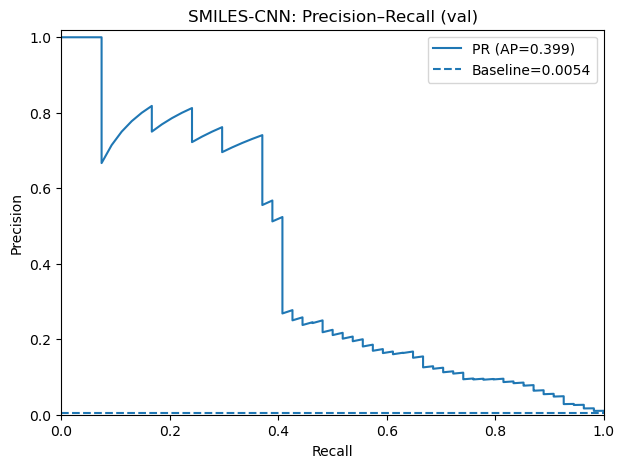

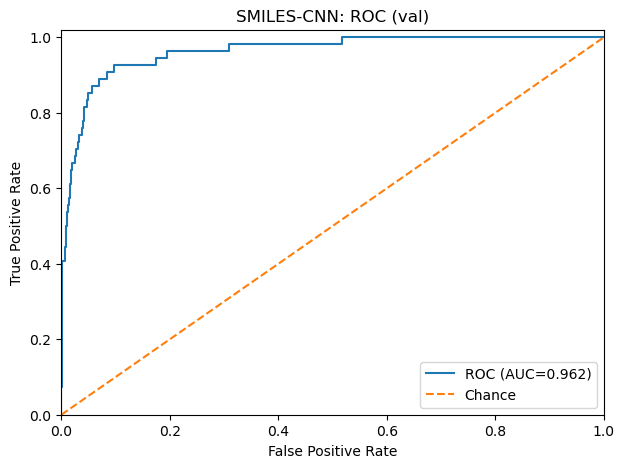

Saved figures to:
 • /Users/pabloperezgonzalez/cpii/F.I.T-PROTEINS/notebooks/neural_networks/artifacts/smiles_cnn_pr_curve.png
 • /Users/pabloperezgonzalez/cpii/F.I.T-PROTEINS/notebooks/neural_networks/artifacts/smiles_cnn_roc_curve.png


In [10]:
# Cell 5 — PR & ROC curves on validation; save figures to artifacts/

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, average_precision_score, roc_auc_score, f1_score
from pathlib import Path
import torch

assert 'model' in globals(), "Run Cell 4 first to train the model."
assert 'val_loader' in globals(), "Run Cell 3 first to build loaders."
device = next(model.parameters()).device

# ---- collect validation probabilities ----
model.eval()
y_true, y_prob = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        logits = model(xb)
        y_prob.append(torch.sigmoid(logits).cpu().numpy())
        y_true.append(yb.numpy())

y_true = np.concatenate(y_true).astype(int)
y_prob = np.concatenate(y_prob)

# ---- metrics for titles ----
ap  = average_precision_score(y_true, y_prob)
auc = roc_auc_score(y_true, y_prob)
prev = y_true.mean()

# pick threshold by F1 (report only; plots are threshold-free)
thr_grid = np.linspace(0.01, 0.99, 99)
f1s = [f1_score(y_true, (y_prob >= t).astype(int), zero_division=0) for t in thr_grid]
t_star = float(thr_grid[int(np.argmax(f1s))])
f1_star = float(np.max(f1s))

print(f"Validation: AP={ap:.4f}, ROC-AUC={auc:.4f}, prevalence={prev:.6f}, F1*={f1_star:.4f} @ thr={t_star:.2f}")

# ---- PR curve ----
prec, rec, _ = precision_recall_curve(y_true, y_prob)
plt.figure(figsize=(7,5))
plt.plot(rec, prec, label=f"PR (AP={ap:.3f})")
plt.hlines(prev, 0, 1, linestyles="dashed", label=f"Baseline={prev:.4f}")
plt.xlim(0,1); plt.ylim(0,1.02)
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("SMILES-CNN: Precision–Recall (val)")
plt.legend(loc="best")
out_dir = Path("artifacts"); out_dir.mkdir(parents=True, exist_ok=True)
pr_path = out_dir / "smiles_cnn_pr_curve.png"
plt.savefig(pr_path, dpi=160, bbox_inches="tight")
plt.show()

# ---- ROC curve ----
fpr, tpr, _ = roc_curve(y_true, y_prob)
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f"ROC (AUC={auc:.3f})")
plt.plot([0,1],[0,1], linestyle="--", label="Chance")
plt.xlim(0,1); plt.ylim(0,1.02)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.title("SMILES-CNN: ROC (val)")
plt.legend(loc="lower right")
roc_path = out_dir / "smiles_cnn_roc_curve.png"
plt.savefig(roc_path, dpi=160, bbox_inches="tight")
plt.show()

# (optional) save arrays for later analysis
np.save(out_dir / "smiles_cnn_val_y.npy",   y_true)
np.save(out_dir / "smiles_cnn_val_prob.npy", y_prob)

print("Saved figures to:")
print(" •", pr_path.resolve())
print(" •", roc_path.resolve())


In [11]:
# Cell 6 — Validation Precision@K and Test predictions

import numpy as np
import pandas as pd
import torch
from pathlib import Path

assert 'model' in globals() and 'val_loader' in globals(), "Run Cells 3–5 first."
device = next(model.parameters()).device
out_dir = Path("artifacts"); out_dir.mkdir(parents=True, exist_ok=True)

# ---------- (A) Validation diagnostics: Precision@K ----------
# Reuse val probabilities if we already have them from Cell 5; else recompute.
try:
    y_true, y_prob  # from Cell 5
except NameError:
    model.eval()
    y_true, y_prob = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            prob = torch.sigmoid(model(xb)).cpu().numpy()
            y_prob.append(prob); y_true.append(yb.numpy())
    y_true = np.concatenate(y_true).astype(int)
    y_prob = np.concatenate(y_prob)

order = np.argsort(-y_prob)  # descending
y_sorted = y_true[order]

def precision_at_k(y_sorted, k):
    k = min(k, len(y_sorted))
    return float(y_sorted[:k].mean())

for k in [25, 50, 100, 200, 500, 1000]:
    print(f"P@{k:>4} = {precision_at_k(y_sorted, k):.4f}")

# Save validation arrays for later
np.save(out_dir / "smiles_cnn_val_y.npy",   y_true)
np.save(out_dir / "smiles_cnn_val_prob.npy", y_prob)

# ---------- (B) Test predictions: probabilities + optional CSV with IDs ----------
# We rely on TEST_PATH, SMILES_COL, the tokenizer/vocab (atomwise_tokenize, stoi, PAD_IDX, MAX_LEN)
assert 'TEST_PATH' in globals() and TEST_PATH.exists(), "TEST_PATH not available; re-run Cell A (bootstrap) to set it."
assert 'atomwise_tokenize' in globals() and 'stoi' in globals() and 'PAD_IDX' in globals() and 'MAX_LEN' in globals()

df_test = pd.read_parquet(TEST_PATH)

# Make sure the SMILES column name exists in the test file; fall back if needed.
if SMILES_COL not in df_test.columns:
    # fallbacks commonly seen
    for alt in ["molecule_smiles", "smiles", "SMILES", "smiles_clean", "smiles_str", "mol_smiles"]:
        if alt in df_test.columns:
            print(f"[info] Using SMILES column '{alt}' for test (SMILES_COL '{SMILES_COL}' not present).")
            SMILES_COL_TEST = alt
            break
    else:
        raise KeyError(f"Could not find a SMILES column in test file. Columns: {list(df_test.columns)}")
else:
    SMILES_COL_TEST = SMILES_COL

# Encode test SMILES with the same vocab
def encode(tokens, max_len=MAX_LEN, stoi=stoi, PAD_IDX=PAD_IDX):
    ids = [stoi.get(t, stoi.get("<UNK>", 1)) for t in tokens][:max_len]
    if len(ids) < max_len:
        ids += [PAD_IDX] * (max_len - len(ids))
    return np.asarray(ids, dtype=np.int32)

smiles_test = df_test[SMILES_COL_TEST].astype(str).tolist()
tok_test = [atomwise_tokenize(s) for s in smiles_test]
X_test = np.vstack([encode(t) for t in tok_test])

# Mini dataloader to avoid big memory spikes
import torch.utils.data as tud
test_loader = tud.DataLoader(
    [torch.from_numpy(row).long() for row in X_test],
    batch_size=512, shuffle=False, num_workers=0
)

model.eval()
probs = []
with torch.no_grad():
    for xb in test_loader:
        xb = xb.to(device)
        probs.append(torch.sigmoid(model(xb)).cpu().numpy())
probs = np.concatenate(probs).ravel()

# Save outputs
proba_path = out_dir / "smiles_cnn_test_proba.npy"
np.save(proba_path, probs)
print("Saved test probabilities →", proba_path.resolve())

# If an id column exists, save a CSV too
id_col = None
for cand in ["id", "molecule_id", "row_id"]:
    if cand in df_test.columns:
        id_col = cand
        break

if id_col:
    csv_path = out_dir / "smiles_cnn_test_predictions.csv"
    pd.DataFrame({"id": df_test[id_col].values, "proba": probs}).to_csv(csv_path, index=False)
    print("Saved CSV with ids →", csv_path.resolve())
else:
    print("[info] No id column found in test file; skipped CSV.")


P@  25 = 0.7200
P@  50 = 0.4400
P@ 100 = 0.2400
P@ 200 = 0.1650
P@ 500 = 0.0880
P@1000 = 0.0490
Saved test probabilities → /Users/pabloperezgonzalez/cpii/F.I.T-PROTEINS/notebooks/neural_networks/artifacts/smiles_cnn_test_proba.npy
Saved CSV with ids → /Users/pabloperezgonzalez/cpii/F.I.T-PROTEINS/notebooks/neural_networks/artifacts/smiles_cnn_test_predictions.csv
